# 資料處理 (不重要)

In [1]:
import re, pymysql, os, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus']=False
from collections import Counter

def get_data_from_sql(table_name, keyword, keyword_type):
    contents_list=[]
    db = pymysql.connect(host="18.217.252.187",port=3306, user="public_author",passwd="antimoneylaunderingisgood2",db="AML_News",charset='utf8')
    try:
        with db.cursor() as cursor:
            sql0 = "SELECT * FROM `" + table_name + "` WHERE '" + keyword +"' LIKE CONCAT('%', `" + keyword_type + "`, '%')"
            cursor.execute(sql0)
            contents_list = cursor.fetchall()
        db.commit()
    finally:
        db.close()
    return contents_list

def find_name(content):
    output_dataframe = get_data_from_sql('apple_daily_people', content ,'keyword')
    output_dataframe2 = get_data_from_sql('judical_criminal_people', content, 'keyword')
    namelist = []
    for i in range(0,len(output_dataframe)):
        namelist.append(output_dataframe[i][0])
    for i in range(0,len(output_dataframe2)):
        namelist.append(output_dataframe2[i][0])
    namelist2 = list(set(namelist)) #remove duplicates
    namelist2.sort(key=namelist.index) #keep the order
    return(namelist2)

def TDM_making(word):
    dic = {}
    for w in word:
        dic[w] = find_name(w) #先選定3個字以上的
    df = pd.DataFrame(columns = ["name"])
    for i in word:
        dff = pd.DataFrame({"name": dic[i], i: 1})
        #print(dff)
        df = pd.merge(df, dff, on = 'name', how='outer')
    df = df.fillna(0) #replace NA with 0
    matrix = df.set_index(['name'])
    return matrix

def TDM_to_CoMatrix(matrix):
    cooccurrence_matrix = np.dot(matrix.transpose(),matrix)
    cooccurrence_matrix_diagonal = np.diagonal(cooccurrence_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        cooccurrence_matrix_percentage = np.nan_to_num(np.true_divide(cooccurrence_matrix, cooccurrence_matrix_diagonal[:, None]))
    #print('\ncooccurrence_matrix_percentage:\n{0}'.format(cooccurrence_matrix_percentage))
    cooccurrence = pd.DataFrame(cooccurrence_matrix_percentage,columns = matrix.columns.values.tolist(), index = matrix.columns.values.tolist())
    return(cooccurrence)

import seaborn as sns # 另一個繪圖-樣式套件
plt.style.use('ggplot')

# 忽略警告訊息
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#全部事件
word = ['人口販運', '性剝削', '偽造貨幣', '殺人', '重傷害', '搶奪' , '勒索' , '海盜', '恐怖主義', '資恐', '非法販運武器'
        , '贓物', '竊盜', '綁架', '拘禁', '妨礙自由', '環保犯罪', '偽造文書', '仿冒', '侵害商業秘密', '毒品犯運', '詐欺'
        , '走私', '稅務犯罪', '組織犯罪', '證卷犯罪', '貪汙賄賂', '洗錢']

#低風險事件
LowRisk = ["人口販運", "性剝削", "偽造貨幣", "殺人", "重傷害", "搶奪", "勒索", "海盜", "恐怖主義", "資恐"]
#中風險
MiddleRisk = ["非法販運武器", "贓物", "竊盜", "綁架", "拘禁", "妨礙自由", "環保犯罪", "偽造文書"]
#高風險
HighRisk = ["仿冒", "侵害商業秘密", "毒品犯運", "詐欺", "走私", "稅務犯罪", "組織犯罪", "證卷犯罪", "貪汙賄賂", "洗錢"]

### 建立所有關鍵字的Matrix

In [3]:
#matrix = TDM_making(word)
#ALL_matrix = TDM_to_CoMatrix(matrix)

In [4]:
#ALL_matrix.head()

### 儲存矩陣

In [5]:
#ALL_matrix.to_csv('matrix2.csv')
#ALL_matrix.to_excel('matrix2.xlsx')

# 讀取矩陣畫圖 (從這裡開始~~)

In [6]:
#基本上可以直接從這個matrix取值出來畫圖
ALL_matrix2 = pd.read_excel("matrix2.xlsx")

# 用這個矩陣完成所有關鍵字的繪圖

In [7]:
import networkx as nx
import numpy as np

def draw_CoOccurrence(df, target_word):
    #add weights to edges
    edge_list = [] #test networkx
    node_list = []
    for index, row in df.iterrows():
        i = 0
        for col in row:
            if index == df.columns[i]:
                node_list.append((index, col))
            else:
                edge_list.append((index, df.columns[i], col))
            #edge_list.append((index, df.columns[i], col))
            i += 1

    #set canvas size
    plt.subplots(figsize=(14,14))

    #networkx graph time!
    G = nx.Graph()
    for i in node_list:
        G.add_node(i[0], size = i[1])
    G.add_weighted_edges_from(edge_list)
    
    #drawing custimization
    test = nx.get_edge_attributes(G, 'weight')
    edge_sum = 0.0
    edge_count = 1
    for n in test:
        edge_sum += test[n]
        edge_count += 1
    edge_mean = edge_sum / edge_count
    
    node_scalar = 1000
    edge_scalar = 30
    sizes = [x[1]*node_scalar for x in node_list]
    widths = [x[2]*edge_scalar if x[2] >= edge_mean else x[2]*10 for x in edge_list]

    #draw the graph
    pos = nx.spring_layout(G, k=0.42, iterations=17)

    nx.draw(G, pos, with_labels=True, font_size = 15, font_weight = 'bold', 
            node_size = sizes, width = widths)

In [8]:
#製作指定關鍵字組成的矩陣，畫出熱點圖及共現圖
def drawing_target_heatmap(lists, min_set, max_set):
    """
    使用者輸入想要畫熱點圖的關鍵字
    依關鍵字畫出熱點圖
    """
    df = ALL_matrix2[lists]
    target_matrix = df.ix[lists]
    sns.set_palette("Set1", 8, .75)
    sns.heatmap(target_matrix, cmap="YlGnBu", vmin = min_set, annot = False, vmax = max_set)
    plt.show()
    
def drawing_target_matrix(lists):
    """
    使用者輸入想要畫共現圖的關鍵字
    依關鍵字畫出共現圖
    """
    df = ALL_matrix2[lists]
    target_matrix = df.ix[lists]
    draw_CoOccurrence(target_matrix, lists)

# 範例: 輸入洗錢、人口販運、綁架

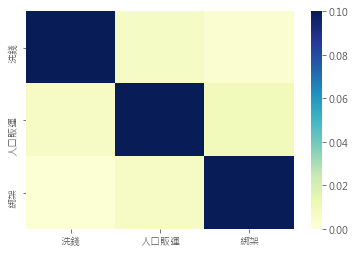

In [9]:
lis = ["洗錢","人口販運","綁架"]
drawing_target_heatmap(lis, 0, 0.1)

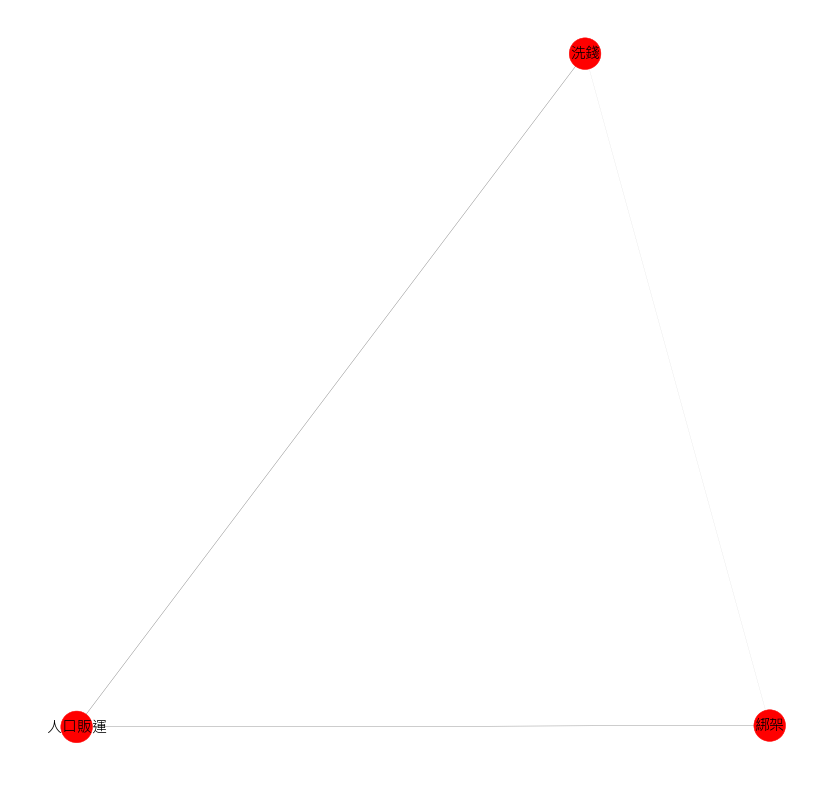

In [10]:
drawing_target_matrix(lis)

# 全部事件圖

全部事件熱點圖


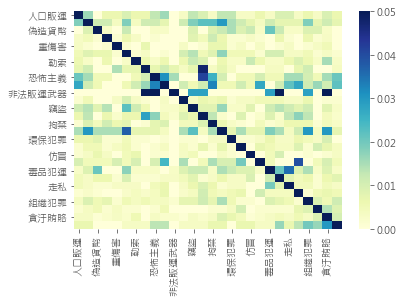

In [11]:
print("全部事件熱點圖")
drawing_target_heatmap(word, 0, 0.05)

全部事件共現圖


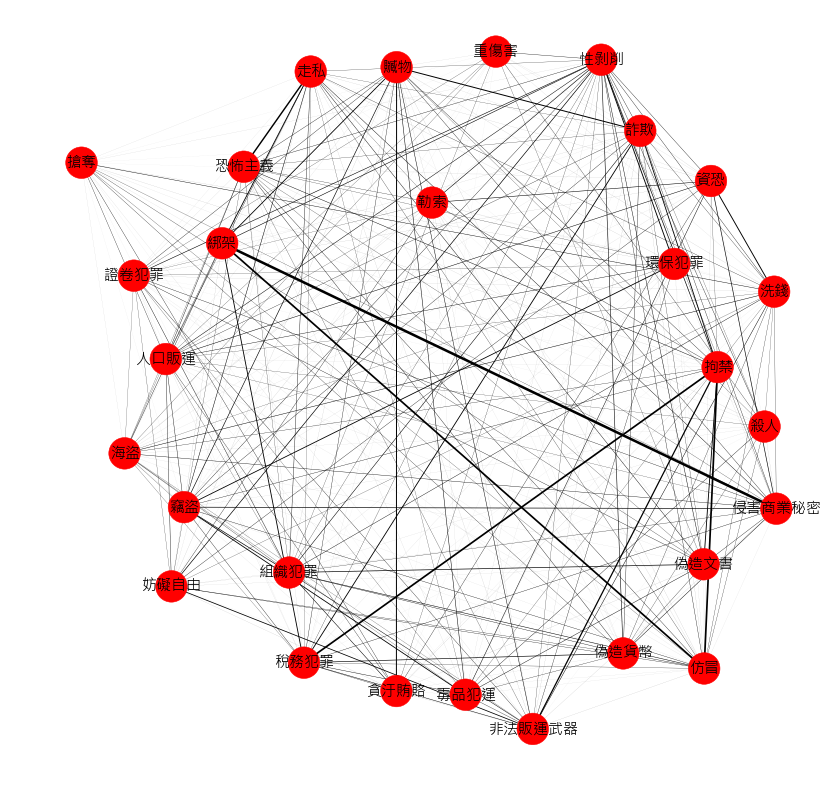

In [12]:
print("全部事件共現圖")
drawing_target_matrix(word)